In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

In [7]:
Train_path = "../datasets/adult/adult.csv"
Test_path = "../datasets/adult/adult.csv"
train_df = pd.read_csv(Train_path, header = None)
test_df = pd.read_csv(Test_path, header = None)
train_df = train_df.iloc[1: , :]
test_df = test_df.iloc[1:, :]

In [8]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
2,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
3,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
4,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [9]:
train_df[14].value_counts()

<=50K    37155
>50K     11687
Name: 14, dtype: int64

In [10]:
label_encoder = LabelEncoder()

for i in range(0, 15):
    train_df[i] = label_encoder.fit_transform(train_df[i])
    test_df[i] = label_encoder.fit_transform(test_df[i])

    

In [11]:
test_df[14].value_counts()

0    37155
1    11687
Name: 14, dtype: int64

In [12]:
X_train, y_train = train_df.values[:, :-1], train_df.values[:, -1]
X_test, y_test = test_df.values[:, :-1], test_df.values[:, -1]

In [13]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [14]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1

    Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
   
        

In [15]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.804451
Error Rate: 0.19554891282093279
Mean Recall: 0.6417940198279722
Balanced Accuracy Score: 0.6417940198279722
Precision: 0.7552962520722226
F-Score: 0.6639560643934084
Selectivity: 0.9537343560758983
G_mean: 0.7823688428318152


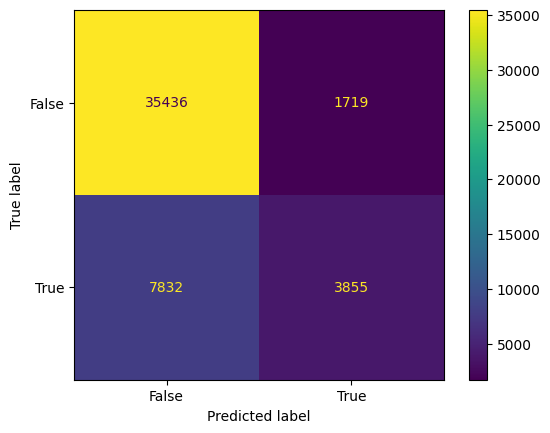

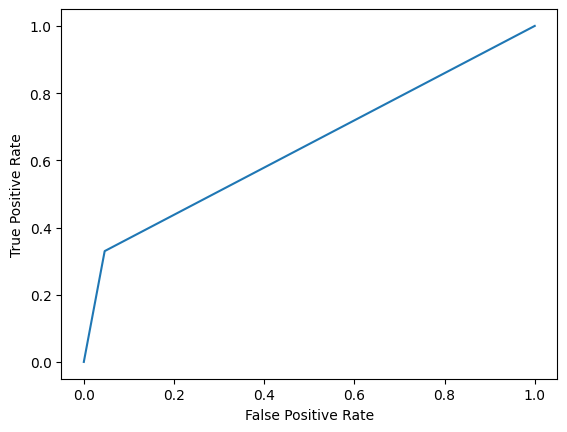

In [16]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.853794
Error Rate: 0.1462061340649441
Mean Recall: 0.8912633057073365
Balanced Accuracy Score: 0.8912633057073365
Precision: 0.8062788459068739
F-Score: 0.8271071712427596
Selectivity: 0.8194051944556587
G_mean: 0.854579301366651


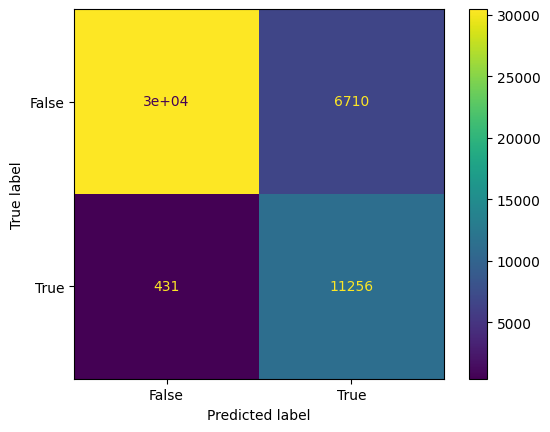

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.852893
Error Rate: 0.14710699807542693
Mean Recall: 0.8908764696702489
Balanced Accuracy Score: 0.8908764696702489
Precision: 0.805565421788046
F-Score: 0.8262333196510324
Selectivity: 0.8180325662764096
G_mean: 0.8536779045516065


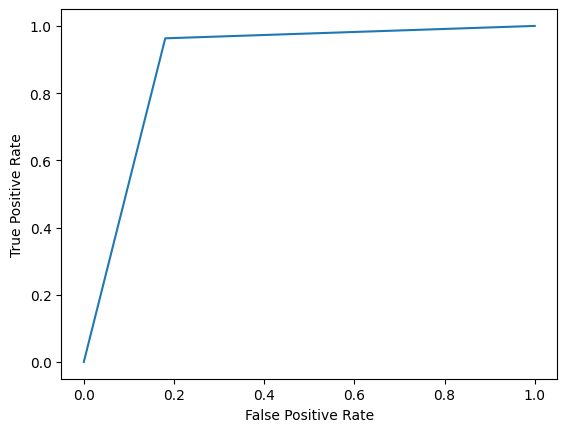

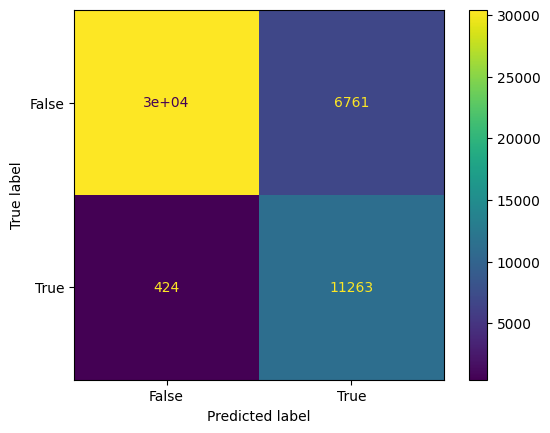

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.850436
Error Rate: 0.1495638999221981
Mean Recall: 0.8886751041903471
Balanced Accuracy Score: 0.8886751041903471
Precision: 0.8032891585080377
F-Score: 0.8235979699564604
Selectivity: 0.8153411384739604
G_mean: 0.8512187563629122


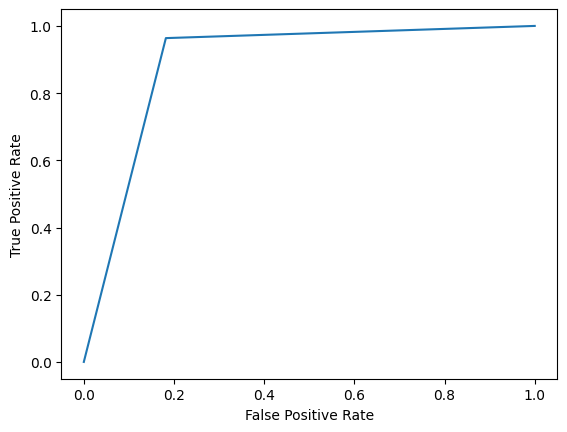

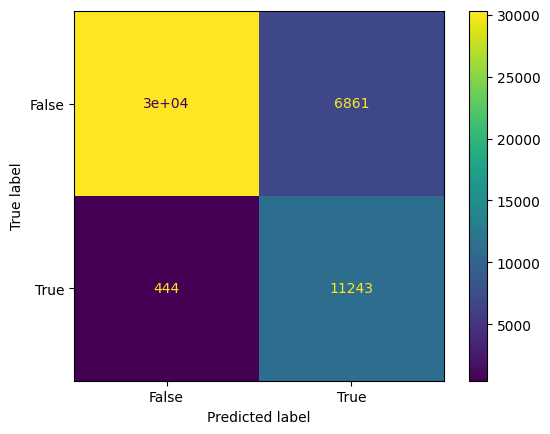

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.849453
Error Rate: 0.1505466606609066
Mean Recall: 0.8878532088782297
Balanced Accuracy Score: 0.8878532088782297
Precision: 0.8024013659205894
F-Score: 0.8225590819670442
Selectivity: 0.8142107387969317
G_mean: 0.8502350364128557


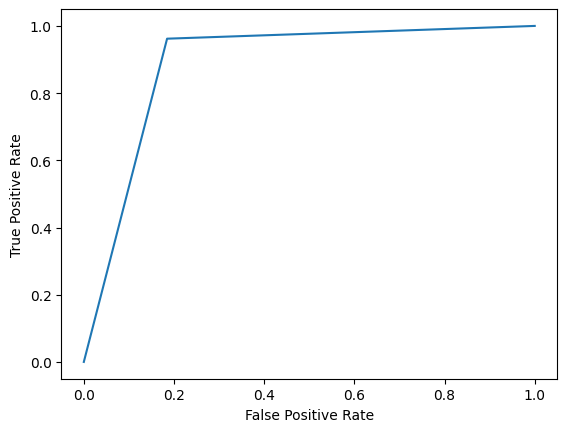

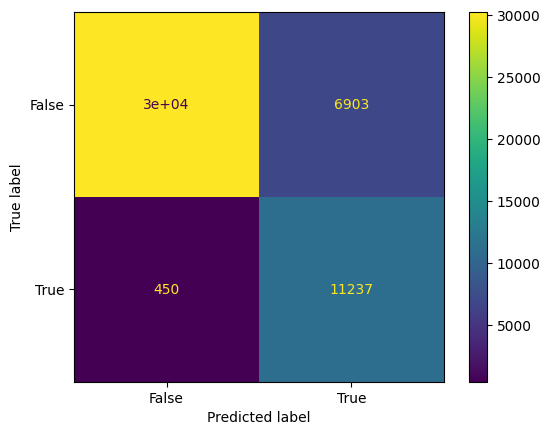

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.848901
Error Rate: 0.15109946357643012
Mean Recall: 0.8863461739679562
Balanced Accuracy Score: 0.8863461739679562
Precision: 0.801574681907905
F-Score: 0.82173646872557
Selectivity: 0.8145337101332257
G_mean: 0.8496816095129451


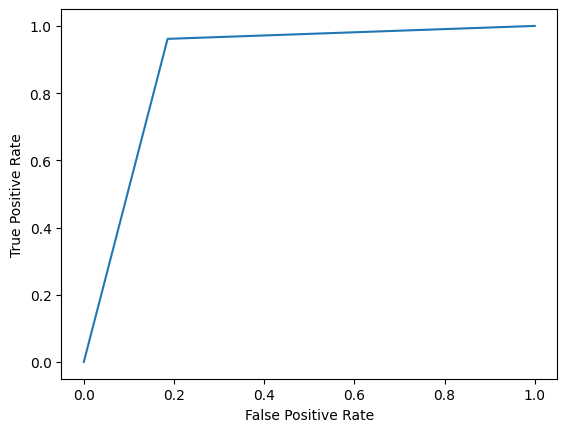

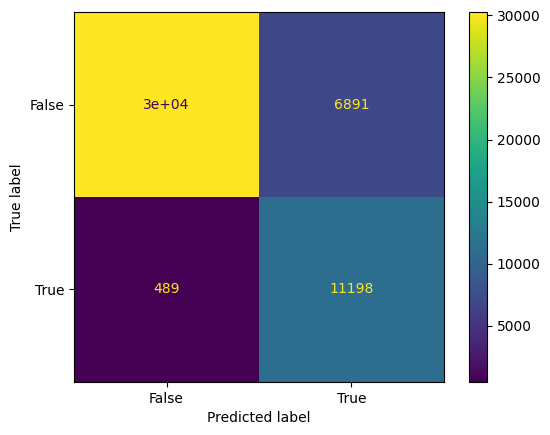

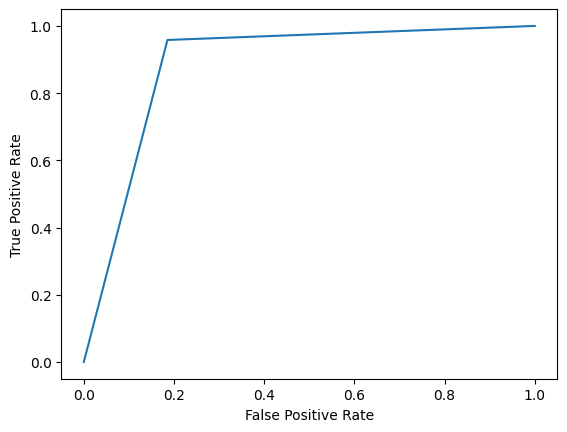

In [17]:
sm_list = []
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.857377
Error Rate: 0.14262315220506938
Mean Recall: 0.8839115844204259
Balanced Accuracy Score: 0.8839115844204259
Precision: 0.806889613186861
F-Score: 0.8285546371258576
Selectivity: 0.8330238191360517
G_mean: 0.8580905568950761


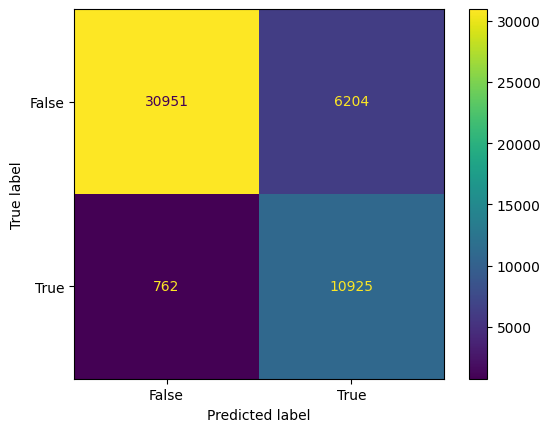

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.853118
Error Rate: 0.14688178207280622
Mean Recall: 0.8790597187113659
Balanced Accuracy Score: 0.8790597187113659
Precision: 0.8024615367540184
F-Score: 0.8236769713175074
Selectivity: 0.8293096487686717
G_mean: 0.8538224092697557


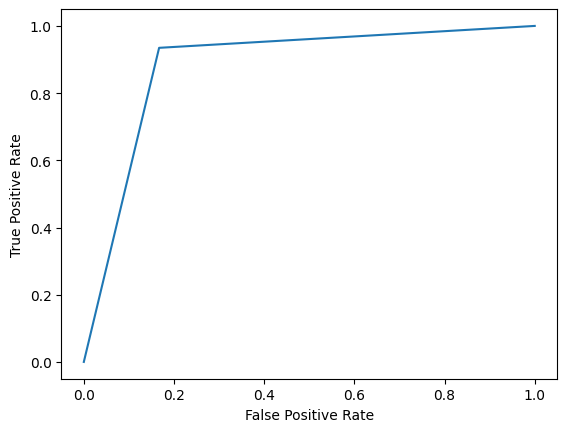

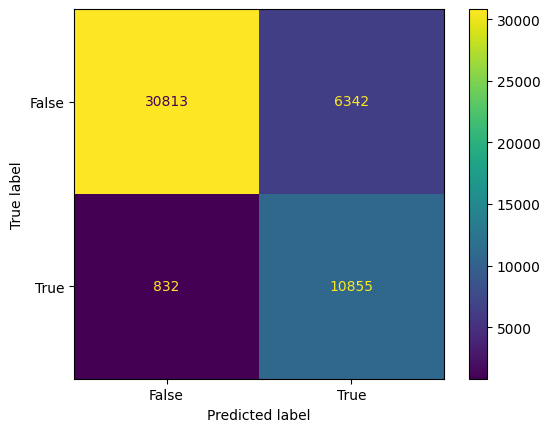

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.848204
Error Rate: 0.15179558576634866
Mean Recall: 0.8717537691993229
Balanced Accuracy Score: 0.8717537691993229
Precision: 0.7969322838149437
F-Score: 0.817638910650306
Selectivity: 0.8265913066881981
G_mean: 0.8488722443293986


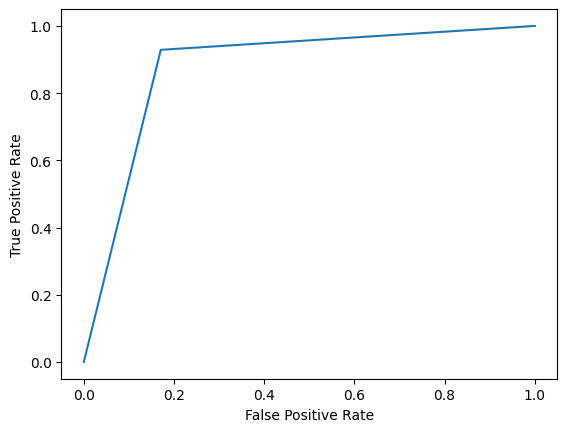

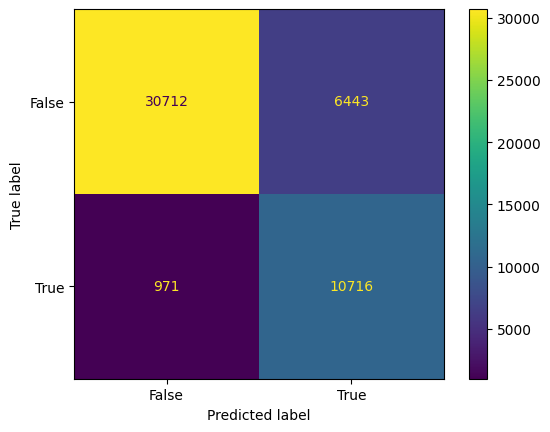

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.852197
Error Rate: 0.14780312026534537
Mean Recall: 0.8653456758108542
Balanced Accuracy Score: 0.8653456758108542
Precision: 0.7986458443725561
F-Score: 0.8194260761424101
Selectivity: 0.8401291885345176
G_mean: 0.8526442167872991


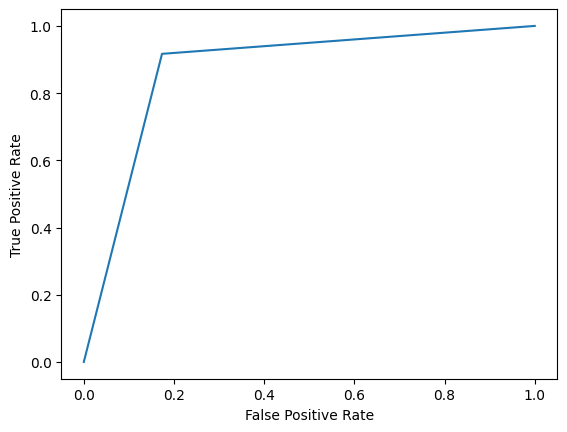

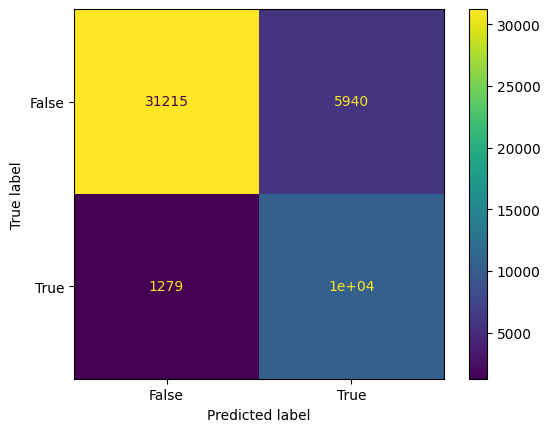

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.848716
Error Rate: 0.151283731214938
Mean Recall: 0.8509172300512249
Balanced Accuracy Score: 0.8509172300512249
Precision: 0.7929492058211585
F-Score: 0.8125028447513851
Selectivity: 0.8466962723724936
G_mean: 0.8488041274533835


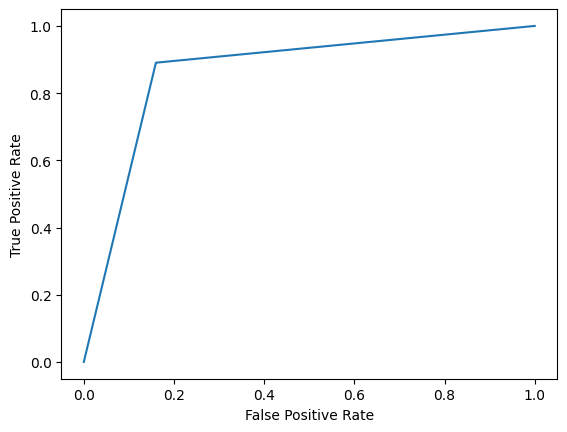

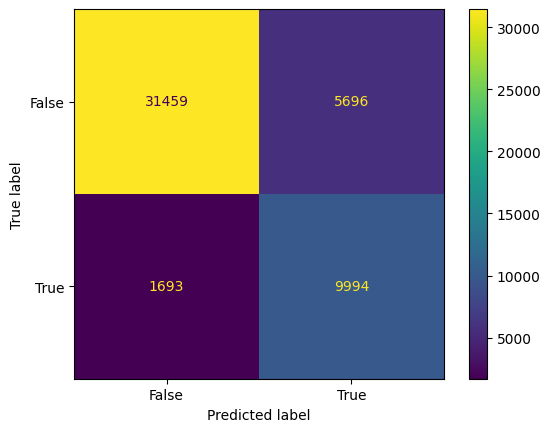

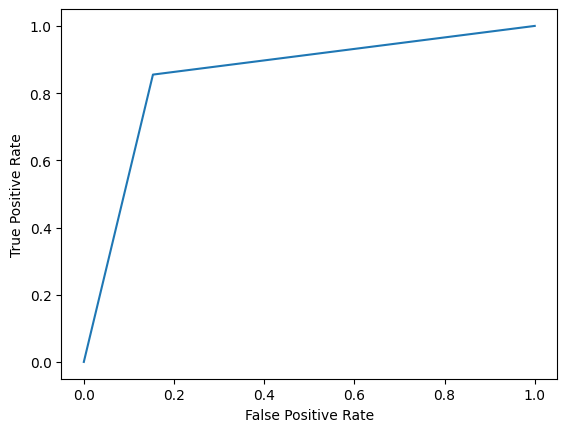

In [18]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)